In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
def coordinates(targets, min_x, max_x, min_y, max_y):
    """
    This function generates random coordinates for given targets
    
    Args:
        targets : number of targets (int)
        min_x : lower x coordinate of bounding box (int)
        max_x : upper x coordinate of bounding box (int)
        min_y : lower y coordinate of bounding box (int)
        max_y : upper y coordinate of bounding box (int)
        
    Returns:
        coordinates : zipped tuple of x, y coordinates , could be used as list(coordinates) 
        x : list of x coordinates for specified number of targets
        y : list of y coordinates for specified number of targets
    """
    x = random.sample(range(min_x, max_x), targets)
    y = random.sample(range(min_y, max_y), targets)
    coordinates = zip(x,y)
    return coordinates, x, y

In [3]:
def deterministic_sensor_coordinates(x_loop, y_loop):
    """
    This function gives deterministic(predefined) equi-distant sensor coordinates
    ** Made by deterministic fron random based on TA response 
    
    Args:
        x_loop : list of x coordinates to be used
        y_loop : list of y coordinates to be used
        
    Returns:
        s_coords : zipped tuple of x, y coordinates , could be used as list(coordinates) 
        s_x_c_list : list of x coordinates for specified number of targets
        s_y_c_list : list of y coordinates for specified number of targets
    """
    s_x_c_list = []
    s_y_c_list = []

    for x_i in x_loop:
        for y_i in y_loop:
            x_l = x_i
            y_l = y_i
            s_x_c_list.append(x_l)
            s_y_c_list.append(y_l)
            
    s_coords = zip(s_x_c_list,s_y_c_list)
    return s_coords, s_x_c_list, s_y_c_list

In [4]:
class Sensor:
    """
        Class to model uniform behavior for all sensors by defining atributes and initial parameters
    """
    
    def __init__(self, x, y, cost, r_0, state):
        """
        Initializes the sensor object with coordinates , cost , range assignment and state
        """
        self.x = x
        self.y = y
        self.cost = cost
        self.r_0 = r_0
        self.state = state
    
    def data(self):
        """
        Utilized to get data during cost optimization problem 
        """
        return self.x, self.y, self.cost, self.r_0, self.state

In [5]:
def cost_to_range(cost_list, range_list): 
    """
    This function maps cost to range for sensors
    
    Args:
        cost_list = list containing the possible costs for sensor nodes
        range_list = list containing the possible ranges for sensor nodes
    Returns:
        cost_range_dict = dictionary with cost as key and range as value
    """
    
    #captures error if different cost and range list are passed
    assert len(cost_list) == len(range_list), "Cost list length not equal to range list" 
    cost_range_dict = {cost_list[i]: range_list[i] for i in range(len(cost_list))}
    return cost_range_dict

In [6]:
def sensor_initialization(cost_range_dict, sensor_coordinates):
    """
    This function initializes the sensor class object and maps range and cost to it
    
    Args:
        cost_range_dict : dictionary with cost as key and range as value from `cost_to_range` method
        sensor_coordinates : initial sensor coordinates generated from `deterministic_sensor_coordinates` method
    
    Returns:
        sensors : an iterable sensor class object module
    """
    sensors = list()
    for i in range(len(sensor_coordinates)):
        #sensor_coordinates is passed as a 2D list
        x = sensor_coordinates[i][0] #first element
        y = sensor_coordinates[i][1] # second elememt
        cost = random.choice(list(cost_range_dict.keys()))
        r_0 = cost_range_dict[cost]
        state = False #initially all node's state are set to False
        sensors.append(Sensor(x, y, cost, r_0, state)) #object of class Sensor initialized
    return sensors

In [7]:
def surviellance(target_coordinates, sensor, targets_prev):
    """
    This function is used to calculate if taget node is within 
    Eucidean distance of range of sensor or not
    
    Args:
        target_coordinates : randomly generated 17 target coordinates
        sensor : a randomly choosen sensor object of Sensor class
        targets_prev : list of targets that have been covered by sensor, to keep track of connectivity degree
    
    Returns:
        t : coordinates of target that is within the range of sensor and is not previously covered
        cnt : counts how many targets are covered by chosen sensor
    """
    cnt = 0
    x_s = sensor.x
    y_s = sensor.y
    r_s = sensor.r_0
    t = targets_prev
    #print("Targets prev in surviellance", t)
    #print("Sensors coordinates and range in surviellance",x_s, y_s, r_s)
    for i in range(len(target_coordinates)):
        x = (x_s - target_coordinates[i][0]) **2
        y = (y_s - target_coordinates[i][1]) **2
        #print("Target coordinates in surviellance are :",target_coordinates[i])
        euclidean_distance = math.sqrt(x + y)
        if (euclidean_distance <= r_s) and (target_coordinates[i] not in t) and (len(target_coordinates) != len(t)):
            print(f'The target located at {target_coordinates[i]} is covered by sensor located at {x_s, y_s}')
            cnt += 1
            #print("Count", cnt)
            t.append(target_coordinates[i])
    return t, cnt

In [8]:
def neighbor(sensor, sensors_list):
    """
    This function finds the next sensor that is not already used to traverse all the targets
    
    Args:
        sensor : randomly choosen single sensor from iterable sensor objects
        sensors_list : list of all sensors
        
    Returns:
        Next sensor to be used in surveillance method
    """
    
    x = []
    for i in range(len(sensors_list)):
        for i in range(len(sensors_list)):
            if ([sensors_list[i].x, sensors_list[i].y] != [sensor.x, sensor.y]):
                x.append(sensors_list[i])
    return random.choice(x)

In [9]:
def simulated_annealing(sensors_list, target_coordinates, n_iterations):
    """
    This function implements simulated annealing, a global optimization algorithm 
    for cost optimization in our context. We model temperature as function of total 
    iterations and use a threshold acceptance probability as random number to accept
    or reject the change in cost for concerned sensor node
    
    Args:
        sensor_list : iteratable object list of all sensor nodes after sensor node initialization
        target_coordinates : list of coordinates of all 17 targets randomly initialized
        n_iterations : total number of iterations/steps the process is to be run
        
    Returns:
        sensors : list of sensors which are able to cover target 
        costs : list of costs associated with sensors that in surveillance range of target
        targets_prev : list of targets in surveillannce range
        i : current iteration/ step
    """
    
    sensor_i = random.choice(sensors_list) # random selection of sensor node
    cost = sensor_i.cost
    sensors, costs, targets_prev = [], [], []
    targets_prev, count = (surviellance(target_coordinates, sensor_i, targets_prev))
    #print("Targets_prev, count : ",targets_prev, count)
    if (count > 0) : #covers the target
        #print("sensor_i.x", sensor_i.x)
        sensor_i.state = True #state changed from initial False(OFF)
        sensors.append(sensor_i)
        #costs.append(cost)
        print()
    for i in range(n_iterations):
        step_size = i / (n_iterations) #change in temperature(exploaration step)
        #print("Step size",step_size)
        temp = max(0.01, min(1, 1-step_size))
        #print("temp", temp)
        new_sensor = neighbor(sensor_i, sensors_list) #next neighbor
        new_cost = new_sensor.cost
        if len(targets_prev) < len(target_coordinates) :
            c = cost / 300
            nc = new_cost / 300
            prob = (np.exp( - (nc - c) / temp  ) if nc > c else 1 )
            #print("Acceptance Probability is : ", prob)
            if (prob > random.random()):
                targets_prev, count = (surviellance(target_coordinates, new_sensor, targets_prev))
                #print("targets_prev after probability is accepted ", targets_prev)
                if (count > 0) :
                    new_sensor.state = True
                    sensor_i, cost = new_sensor, new_cost
                    sensors.append(sensor_i)
                    costs.append(cost)
                    #print(sensors, cost)
    return sensors, costs, targets_prev, i

In [10]:
def cost(sensors_list):
    """
    This function calculates the initial cost of all the sensors that are initialized
    """
    return sum([sensors_list[i].cost for i in range(len(sensors_list))])

In [11]:
def coverage(target_coordinates, targets_prev):
    """
    This function calculates the coverage ratio based on the targets 
    that are within range of any sensors to total targets(17)
    """
    return round((len(targets_prev) / len(target_coordinates))*100, 2)

In [12]:
#Global variables
n_targets = 17
n_iterations = 2000
#n_sensors = 50
min_x, max_x, min_y, max_y = 0, 500, 0, 500
cost_list, range_list = [300, 170, 65], [100, 70 ,30]

The target located at (279, 279) is covered by sensor located at (260, 260)
The target located at (216, 229) is covered by sensor located at (260, 260)

The target located at (57, 47) is covered by sensor located at (80, 20)
The target located at (114, 13) is covered by sensor located at (80, 20)
The target located at (140, 258) is covered by sensor located at (140, 320)
The target located at (125, 308) is covered by sensor located at (140, 320)
The target located at (71, 287) is covered by sensor located at (80, 260)
The target located at (44, 214) is covered by sensor located at (80, 260)
The target located at (16, 301) is covered by sensor located at (80, 260)
The target located at (52, 366) is covered by sensor located at (80, 380)
The target located at (12, 111) is covered by sensor located at (20, 80)
The target located at (327, 15) is covered by sensor located at (320, 20)
The target located at (456, 359) is covered by sensor located at (480, 440)
The target located at (346, 332

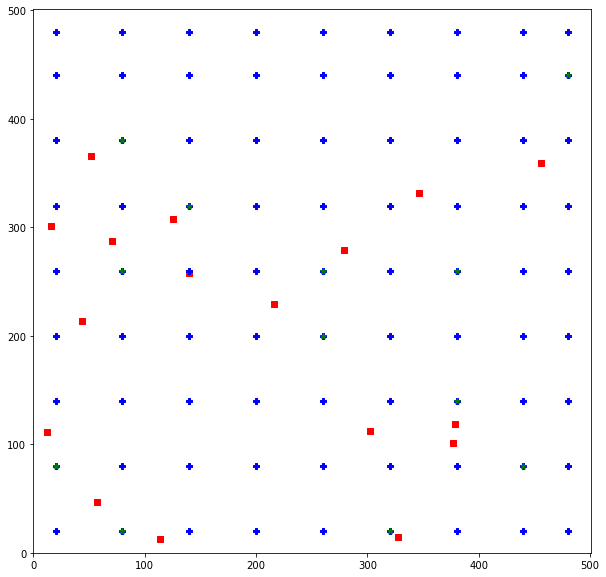

In [13]:
if __name__ == "__main__":
    points = []
    target_coordinates, t_x_coord, t_y_coord  = coordinates(n_targets, min_x, max_x, min_y, max_y)
    target_coordinates = list(target_coordinates)
    x_loop = [20, 80, 140, 200, 260, 320, 380, 440, 480]
    y_loop = [20, 80, 140, 200, 260, 320, 380, 440, 480]
    #x_loop = [40, 140, 240, 340, 440]
    #y_loop = [40, 140, 240, 340, 440]
    sensor_coordinates, s_x_coord, s_y_coord = deterministic_sensor_coordinates(x_loop, y_loop)
    #sensor_coordinates, s_x_coord, s_y_coord = coordinates(n_sensors, min_x, max_x, min_y, max_y)
    sensor_coordinates = list(sensor_coordinates)
    
    plt.figure(figsize = (10,10))
    plt.scatter(t_x_coord, t_y_coord, color = 'red', marker = 's')
    plt.scatter(s_x_coord, s_y_coord, color = 'blue', marker = 'P')
    plt.xlim(min_x, max_x+1)
    plt.ylim(min_y, max_y+1)
    cost_range_dict = cost_to_range(cost_list, range_list)
    sensors_list = sensor_initialization(cost_range_dict, sensor_coordinates)
    sensors, costs, targets_prev, iterations = simulated_annealing(sensors_list, target_coordinates, n_iterations)
    print("Costs after annealing is ",costs)
    print("Steps are : ",iterations)
    print(f'The surveillance zone of {len(targets_prev)} targets is covered by the {len(sensors)} sensors.')
    print(f'Cost before node placement optimization is : {cost(sensors_list)} \
    and after optimization using Simulated Annealing is {sum(costs)}')
    print(f'Coverage ratio is : {coverage(target_coordinates, targets_prev)}')
    points = [(sensors[i].x, sensors[i].y) for i in range(len(sensors))]
    p_x, p_y = zip(*points)
    plt.scatter(list(p_x),list(p_y), color = 'green',  marker = "*")
    plt.show()